# v19 Data Collection & Preprocessing

This notebook handles data collection and preprocessing for the v19 Korean-English cross-lingual SPLADE model.

## Approach

**Embedding-based Synonym Discovery with Quality Constraints**:
1. Load existing term pairs from cross-lingual sources
2. Vectorize terms using multilingual embedding model (e5-large-multilingual)
3. Perform k-means clustering to group semantically similar terms
4. Extract Korean to mixed (Korean + English) term mappings
5. **Limit to max 8 targets per source** with similarity threshold 0.85

## Data Sources

| Source | Description |
|--------|-------------|
| term_pairs.jsonl | High-quality cross-lingual pairs |
| Wikipedia (Optional) | Korean/English Wikipedia articles |

In [1]:
import sys
from pathlib import Path

# Find project root
def find_project_root():
    """Find project root by looking for markers like pyproject.toml or src/"""
    current = Path.cwd()
    for parent in [current] + list(current.parents):
        if (parent / "pyproject.toml").exists() or (parent / "src").exists():
            return parent
    return Path.cwd().parent.parent

PROJECT_ROOT = find_project_root()
sys.path.insert(0, str(PROJECT_ROOT))

print(f"Project root: {PROJECT_ROOT}")

Project root: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train


In [2]:
import json
import re
from collections import defaultdict
from typing import List, Dict, Set, Tuple
import random

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity

# NLP libraries for tokenization and POS tagging
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

# Output directory
OUTPUT_DIR = PROJECT_ROOT / "dataset" / "v19_high_quality"
print(f"Output directory: {OUTPUT_DIR}")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Output directory: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/dataset/v19_high_quality
PyTorch: 2.10.0.dev20251109+cu130
CUDA available: True


## 1. Load Embedding Model

We use multilingual embedding models to vectorize terms:
- **intfloat/multilingual-e5-large**: High-quality multilingual embeddings
- **BAAI/bge-m3**: Alternative multilingual model

In [ ]:
# Configuration
CONFIG = {
    "embedding_model": "intfloat/multilingual-e5-large",  # or "BAAI/bge-m3"
    "max_terms_per_source": 50000,  # Limit terms per language
    "batch_size": 64,
    "n_clusters": 5000,  # Number of k-means clusters
    "min_cluster_size": 2,  # Minimum terms in cluster to consider
    "similarity_threshold": 0.85,  # Increased from 0.8 for higher quality
    "max_targets_per_source": 8,  # Limit targets per Korean term
}

print("Configuration:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")

In [4]:
# Load embedding model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

print(f"\nLoading embedding model: {CONFIG['embedding_model']}...")
embed_tokenizer = AutoTokenizer.from_pretrained(CONFIG["embedding_model"])
embed_model = AutoModel.from_pretrained(CONFIG["embedding_model"])
embed_model = embed_model.to(device)
embed_model.eval()

print(f"Model loaded successfully!")

Device: cuda

Loading embedding model: intfloat/multilingual-e5-large...


/home/west/Documents/cursor-workspace/opensearch-neural-pre-train/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:435: UserWarning: 
    Found GPU0 NVIDIA GB10 which is of cuda capability 12.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (8.0) - (12.0)
    
  queued_call()


Model loaded successfully!


In [5]:
def get_embeddings(texts: List[str], batch_size: int = 64) -> np.ndarray:
    """Get embeddings for a list of texts using the embedding model.
    
    Note: Embeddings are L2-normalized, so dot product = cosine similarity.
    This ensures similarity scores are in range [-1, 1].
    """
    all_embeddings = []
    
    # Add prefix for e5 models
    if "e5" in CONFIG["embedding_model"].lower():
        texts = [f"query: {t}" for t in texts]
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding"):
        batch_texts = texts[i:i + batch_size]
        
        inputs = embed_tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=64,
            return_tensors="pt"
        ).to(device)
        
        with torch.no_grad():
            outputs = embed_model(**inputs)
            # Use mean pooling
            embeddings = outputs.last_hidden_state.mean(dim=1)
            # L2 normalize: dot product of normalized vectors = cosine similarity
            embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)
        
        all_embeddings.append(embeddings.cpu().numpy())
    
    return np.vstack(all_embeddings)

## 2. Extract Terms from Data Sources

We try to extract terms from:
1. Wikipedia (if available)
2. Existing term pairs file (fallback)

In [6]:
# Load NLTK resources
ENGLISH_STOPWORDS = set(stopwords.words('english'))

# POS tags to keep (nouns, verbs, adjectives, adverbs)
# NN: noun, VB: verb, JJ: adjective, RB: adverb
VALID_POS_TAGS = {
    'NN', 'NNS', 'NNP', 'NNPS',  # Nouns
    'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ',  # Verbs
    'JJ', 'JJR', 'JJS',  # Adjectives
}


def is_korean_token(text: str) -> bool:
    """Check if text is a valid Korean token (no spaces, Korean chars only)."""
    if ' ' in text or not text:
        return False
    has_korean = any('\uac00' <= c <= '\ud7a3' for c in text)
    has_english = any('a' <= c.lower() <= 'z' for c in text)
    return has_korean and not has_english


def is_english_token(text: str) -> bool:
    """Check if text is a valid English token (no spaces, letters only)."""
    if ' ' in text or not text:
        return False
    return text.isalpha() and text.isascii()


def clean_token(token: str) -> str:
    """Clean and normalize a token."""
    token = re.sub(r'[^\w가-힣a-zA-Z]', '', token)
    return token.strip()


def filter_english_by_pos(tokens: List[str]) -> List[str]:
    """Filter English tokens by POS tag - keep nouns, verbs, adjectives."""
    if not tokens:
        return []
    
    # POS tagging
    tagged = pos_tag(tokens)
    
    # Keep only valid POS tags
    filtered = [
        token for token, tag in tagged
        if tag in VALID_POS_TAGS
    ]
    
    return filtered


def extract_tokens_from_wikipedia(
    file_path: Path,
    language: str,
    max_tokens: int = 50000,
    min_length: int = 2,
    max_length: int = 15
) -> List[str]:
    """Extract single tokens from Wikipedia article text.
    
    Args:
        file_path: Path to Wikipedia JSONL file
        language: 'ko' for Korean, 'en' for English
        max_tokens: Maximum number of tokens to extract
        min_length: Minimum token length
        max_length: Maximum token length
    
    Returns:
        List of unique single tokens
    """
    token_counts = defaultdict(int)
    
    if not file_path.exists():
        print(f"File not found: {file_path}")
        return []
    
    print(f"Processing: {file_path.name} (language={language})")
    
    is_valid = is_korean_token if language == "ko" else is_english_token
    
    with open(file_path, "r", encoding="utf-8") as f:
        for line in tqdm(f, desc="Reading articles"):
            try:
                article = json.loads(line.strip())
                text = article.get("text", "")
                
                # Split text into words
                words = text.split()
                
                # Collect candidate tokens
                candidates = []
                for word in words:
                    token = clean_token(word)
                    
                    if language == "en":
                        token = token.lower()
                    
                    if not is_valid(token):
                        continue
                    
                    if not (min_length <= len(token) <= max_length):
                        continue
                    
                    # Filter stopwords for English using NLTK
                    if language == "en" and token in ENGLISH_STOPWORDS:
                        continue
                    
                    # Skip single character Korean tokens
                    if language == "ko" and len(token) == 1:
                        continue
                    
                    candidates.append(token)
                
                # POS filtering for English
                if language == "en" and candidates:
                    candidates = filter_english_by_pos(candidates)
                
                # Count tokens
                for token in candidates:
                    token_counts[token] += 1
                
            except json.JSONDecodeError:
                continue
    
    # Sort by frequency and take top tokens
    sorted_tokens = sorted(token_counts.items(), key=lambda x: -x[1])
    top_tokens = [t for t, _ in sorted_tokens[:max_tokens]]
    
    print(f"Extracted {len(top_tokens):,} unique tokens")
    return top_tokens

In [7]:
# Check data sources availability
ko_wiki_path = PROJECT_ROOT / "dataset" / "wikipedia" / "ko_articles.jsonl"
en_wiki_path = PROJECT_ROOT / "dataset" / "wikipedia" / "en_articles.jsonl"
term_pairs_path = OUTPUT_DIR / "term_pairs.jsonl"

print("Data sources check:")
print(f"  Korean Wikipedia: {'Found' if ko_wiki_path.exists() else 'NOT FOUND'}")
print(f"  English Wikipedia: {'Found' if en_wiki_path.exists() else 'NOT FOUND'}")
print(f"  Term pairs: {'Found' if term_pairs_path.exists() else 'NOT FOUND'}")

USE_WIKIPEDIA = ko_wiki_path.exists() and en_wiki_path.exists()
print(f"\nUsing Wikipedia: {USE_WIKIPEDIA}")

Data sources check:
  Korean Wikipedia: NOT FOUND
  English Wikipedia: NOT FOUND
  Term pairs: Found

Using Wikipedia: False


In [8]:
# Extract or load terms
ko_terms = []
en_terms = []

if USE_WIKIPEDIA:
    # Extract from Wikipedia
    print("=" * 70)
    print("Extracting Korean Tokens from Wikipedia")
    print("=" * 70)
    ko_terms = extract_tokens_from_wikipedia(
        ko_wiki_path,
        language="ko",
        max_tokens=CONFIG["max_terms_per_source"],
        min_length=2,
        max_length=10
    )
    
    print("\n" + "=" * 70)
    print("Extracting English Tokens from Wikipedia")
    print("=" * 70)
    en_terms = extract_tokens_from_wikipedia(
        en_wiki_path,
        language="en",
        max_tokens=CONFIG["max_terms_per_source"],
        min_length=3,
        max_length=15
    )
else:
    # Load from existing term_pairs.jsonl
    print("=" * 70)
    print("Loading Terms from term_pairs.jsonl (Wikipedia not available)")
    print("=" * 70)
    
    ko_terms_set = set()
    en_terms_set = set()
    
    if term_pairs_path.exists():
        with open(term_pairs_path, "r", encoding="utf-8") as f:
            for line in f:
                item = json.loads(line.strip())
                ko = item.get("ko", "")
                en = item.get("en", "").lower()
                
                # Validate Korean term
                if ko and len(ko) >= 2 and not all(c.isascii() for c in ko):
                    ko_terms_set.add(ko)
                
                # Validate English term - split multi-word terms
                if en:
                    for word in en.split():
                        word = word.strip()
                        if word.isalpha() and word.isascii() and len(word) >= 3:
                            en_terms_set.add(word)
        
        ko_terms = list(ko_terms_set)
        en_terms = list(en_terms_set)
    else:
        print("WARNING: No data source available!")

print(f"\nKorean tokens: {len(ko_terms):,}")
print(f"English tokens: {len(en_terms):,}")

Loading Terms from term_pairs.jsonl (Wikipedia not available)

Korean tokens: 13,787
English tokens: 15,969


In [9]:
# Sample tokens (should be single words without spaces)
print("Sample Korean tokens:")
for t in ko_terms[:15]:
    print(f"  {t}")

print("\nSample English tokens:")
for t in en_terms[:15]:
    print(f"  {t}")

# Verify no spaces
print("\n" + "=" * 70)
print("Validation Check")
print("=" * 70)
ko_with_space = [t for t in ko_terms if ' ' in t]
en_with_space = [t for t in en_terms if ' ' in t]
print(f"Korean tokens with spaces: {len(ko_with_space)}")
print(f"English tokens with spaces: {len(en_with_space)}")

if not ko_terms or not en_terms:
    raise ValueError("No terms extracted! Check data sources.")

Sample Korean tokens:
  백스트리트
  샌즈
  반란군
  필리핀
  일출
  코러스
  스위스
  상실
  경주
  보나파르트
  미터
  고무
  정원
  양육
  유니언

Sample English tokens:
  stickers
  colombo
  security
  helios
  lord
  jenny
  grids
  keyboard
  soweto
  trek
  ezra
  tailor
  tvxq
  alchemy
  tensor

Validation Check
Korean tokens with spaces: 0
English tokens with spaces: 0


## 3. Generate Embeddings

In [10]:
# Combine all terms
all_terms = ko_terms + en_terms
term_languages = ["ko"] * len(ko_terms) + ["en"] * len(en_terms)

print(f"Total terms: {len(all_terms):,}")
print(f"  Korean: {len(ko_terms):,}")
print(f"  English: {len(en_terms):,}")

Total terms: 29,756
  Korean: 13,787
  English: 15,969


In [11]:
# Generate embeddings for all terms
print("\nGenerating embeddings...")
embeddings = get_embeddings(all_terms, batch_size=CONFIG["batch_size"])
print(f"Embeddings shape: {embeddings.shape}")


Generating embeddings...


Embedding:   0%|          | 0/465 [00:00<?, ?it/s]

Embeddings shape: (29756, 1024)


## 4. K-Means Clustering

In [12]:
# Perform k-means clustering
# Adjust n_clusters based on data size
n_samples = len(all_terms)
n_clusters = min(CONFIG["n_clusters"], n_samples // 5)  # At least 5 samples per cluster
n_clusters = max(n_clusters, 10)  # Minimum 10 clusters

print(f"\nPerforming k-means clustering:")
print(f"  Total terms: {n_samples:,}")
print(f"  Target clusters: {n_clusters:,}")

kmeans = MiniBatchKMeans(
    n_clusters=n_clusters,
    random_state=42,
    batch_size=min(1024, n_samples),
    n_init=3,
    verbose=1
)

cluster_labels = kmeans.fit_predict(embeddings)
print(f"Clustering complete!")


Performing k-means clustering:
  Total terms: 29,756
  Target clusters: 5,000
Init 1/3 with method k-means++
Inertia for init 1/3: 2310.53369140625
Init 2/3 with method k-means++
Inertia for init 2/3: 2304.419921875
Init 3/3 with method k-means++
Inertia for init 3/3: 2306.41650390625
[MiniBatchKMeans] Reassigning 512 cluster centers.
Minibatch step 1/2905: mean batch inertia: 0.1592572033405304
[MiniBatchKMeans] Reassigning 512 cluster centers.
Minibatch step 2/2905: mean batch inertia: 0.15375517308712006, ewa inertia: 0.15375517308712006
[MiniBatchKMeans] Reassigning 512 cluster centers.
Minibatch step 3/2905: mean batch inertia: 0.14423012733459473, ewa inertia: 0.15309961998360921
[MiniBatchKMeans] Reassigning 512 cluster centers.
Minibatch step 4/2905: mean batch inertia: 0.14413750171661377, ewa inertia: 0.15248280988142127
[MiniBatchKMeans] Reassigning 512 cluster centers.
Minibatch step 5/2905: mean batch inertia: 0.1355786770582199, ewa inertia: 0.15131939743991452
[MiniBatc

In [13]:
# Analyze clusters - include language info
cluster_stats = defaultdict(list)  # cluster_label -> [(term, index, language), ...]

for i, (term, lang, label) in enumerate(zip(all_terms, term_languages, cluster_labels)):
    cluster_stats[label].append((term, i, lang))

# Find clusters with both Korean and English terms
bilingual_clusters = [
    (label, items) for label, items in cluster_stats.items()
    if any(l == "ko" for _, _, l in items) and any(l == "en" for _, _, l in items)
]

# Also include clusters with multiple Korean terms (for Korean synonyms)
ko_only_clusters = [
    (label, items) for label, items in cluster_stats.items()
    if sum(1 for _, _, l in items if l == "ko") >= 2 and label not in [b[0] for b in bilingual_clusters]
]

print(f"Total clusters: {CONFIG['n_clusters']:,}")
print(f"Bilingual clusters (KO + EN): {len(bilingual_clusters):,}")
print(f"Korean-only clusters (2+ KO terms): {len(ko_only_clusters):,}")
print(f"Total clusters to process: {len(bilingual_clusters) + len(ko_only_clusters):,}")

Total clusters: 5,000
Bilingual clusters (KO + EN): 274
Korean-only clusters (2+ KO terms): 1,457
Total clusters to process: 1,731


## 5. Extract Korean-English Pairs from Clusters

In [14]:
def extract_similar_terms_from_cluster(
    all_items: List[Tuple[str, int, str]],  # (term, index, language)
    embeddings: np.ndarray,
    threshold: float = 0.7
) -> Dict[str, List[Tuple[str, float]]]:
    """Extract similar terms (both Korean and English) for each Korean term.
    
    Uses DOT PRODUCT similarity (not cosine) for consistency.
    
    Args:
        all_items: List of (term, embedding_index, language) tuples
        embeddings: All term embeddings (normalized)
        threshold: Dot product similarity threshold
    
    Returns:
        Dict mapping Korean term to list of (similar_term, dot_product) tuples
    """
    mappings = defaultdict(list)
    
    # Separate Korean terms (source) from all terms
    ko_items = [(t, i, l) for t, i, l in all_items if l == "ko"]
    
    if not ko_items:
        return dict(mappings)
    
    # Get embeddings
    ko_terms = [item[0] for item in ko_items]
    ko_indices = [item[1] for item in ko_items]
    ko_embeds = embeddings[ko_indices]
    
    all_terms_in_cluster = [item[0] for item in all_items]
    all_indices = [item[1] for item in all_items]
    all_embeds = embeddings[all_indices]
    
    # Compute DOT PRODUCT similarity: Korean terms vs ALL terms
    # For normalized vectors, dot product = cosine similarity
    similarities = np.dot(ko_embeds, all_embeds.T)
    
    # Find similar terms for each Korean term
    for i, ko_term in enumerate(ko_terms):
        for j, (other_term, _, other_lang) in enumerate(all_items):
            # Skip self
            if ko_term == other_term:
                continue
            
            sim = similarities[i, j]
            if sim >= threshold:
                mappings[ko_term].append((other_term, float(sim)))
    
    # Sort by similarity
    for ko_term in mappings:
        mappings[ko_term].sort(key=lambda x: -x[1])
    
    return dict(mappings)

In [15]:
# Extract 1:N mappings with mixed Korean/English terms
# Limit to top MAX_TARGETS_PER_SOURCE by similarity score
print("Extracting similar terms (Korean + English mixed) from clusters...")
print(f"Similarity threshold: {CONFIG['similarity_threshold']}")
print(f"Max targets per source: {CONFIG['max_targets_per_source']}")

# Aggregate all mappings: ko_term -> [(similar_term, sim), ...]
all_mappings: Dict[str, List[Tuple[str, float]]] = defaultdict(list)

# Process bilingual clusters
all_clusters = bilingual_clusters + ko_only_clusters

for label, items in tqdm(all_clusters, desc="Processing clusters"):
    cluster_mappings = extract_similar_terms_from_cluster(
        items,
        embeddings,
        threshold=CONFIG["similarity_threshold"]
    )
    
    # Merge into global mappings
    for ko_term, similar_list in cluster_mappings.items():
        all_mappings[ko_term].extend(similar_list)

# Deduplicate, sort by similarity, and LIMIT to top N
max_targets = CONFIG["max_targets_per_source"]
for ko_term in all_mappings:
    seen = {}
    for term, sim in all_mappings[ko_term]:
        if term not in seen or sim > seen[term]:
            seen[term] = sim
    # Sort by similarity (descending) and limit to top N
    sorted_terms = sorted(seen.items(), key=lambda x: -x[1])[:max_targets]
    all_mappings[ko_term] = sorted_terms

print(f"\nExtracted {len(all_mappings):,} Korean terms with similar terms")
total_terms = sum(len(v) for v in all_mappings.values())
avg_per_ko = total_terms / len(all_mappings) if all_mappings else 0
print(f"Total similar term mappings: {total_terms:,}")
print(f"Average terms per Korean term: {avg_per_ko:.2f} (max: {max_targets})")

# Count Korean vs English in mappings
ko_in_mappings = sum(1 for v in all_mappings.values() for t, _ in v if is_korean_token(t))
en_in_mappings = sum(1 for v in all_mappings.values() for t, _ in v if is_english_token(t))
print(f"\nIn similar terms: {ko_in_mappings:,} Korean, {en_in_mappings:,} English")

Extracting similar terms (Korean + English mixed) from clusters...
Similarity threshold: 0.8
Max targets per source: 8


Processing clusters:   0%|          | 0/1731 [00:00<?, ?it/s]


Extracted 13,063 Korean terms with similar terms
Total similar term mappings: 84,318
Average terms per Korean term: 6.45 (max: 8)

In similar terms: 82,873 Korean, 1,445 English


In [16]:
# Show sample 1:N mappings with mixed Korean/English terms
print("\nSample mappings (Korean -> [Korean + English terms]):")
print("=" * 70)

# Sort by number of terms
sorted_mappings = sorted(all_mappings.items(), key=lambda x: -len(x[1]))

for ko_term, term_list in sorted_mappings[:20]:
    # Separate Korean and English terms for display
    ko_terms_in_list = [f"{t}({sim:.2f})" for t, sim in term_list if is_korean_token(t)][:3]
    en_terms_in_list = [f"{t}({sim:.2f})" for t, sim in term_list if is_english_token(t)][:3]
    
    terms_str = ", ".join(ko_terms_in_list + en_terms_in_list)
    remaining = len(term_list) - len(ko_terms_in_list) - len(en_terms_in_list)
    if remaining > 0:
        terms_str += f" ... (+{remaining} more)"
    
    print(f"  {ko_term} -> [{terms_str}]")

# Distribution
print(f"\n" + "=" * 70)
print("Term count distribution:")
term_counts = [len(v) for v in all_mappings.values()]
print(f"  Min: {min(term_counts)}, Max: {max(term_counts)}, Mean: {np.mean(term_counts):.2f}")


Sample mappings (Korean -> [Korean + English terms]):
  쿼크 -> [쿼츠(0.94), 쿼드(0.93), 쿼터(0.92), quark(0.90), quad(0.87) ... (+3 more)]
  쿼츠 -> [쿼드(0.95), 쿼터(0.94), 쿼크(0.94), quarts(0.90), quad(0.89) ... (+3 more)]
  쿼터백 -> [쿼터(0.90), 쿼츠(0.89), 쿼드(0.89), quarter(0.86), quad(0.86) ... (+3 more)]
  쿼드 -> [쿼츠(0.95), 쿼터(0.94), 쿼크(0.93), quad(0.92), quarts(0.89) ... (+3 more)]
  쿼터 -> [쿼츠(0.94), 쿼드(0.94), 쿼리(0.92), quarter(0.91), quarts(0.90) ... (+3 more)]
  쿼리 -> [쿼터(0.92), 쿼크(0.90), 쿼츠(0.90), quarterly(0.86), quarts(0.85), quark(0.85) ... (+2 more)]
  콰르텟 -> [쿼터(0.90), 쿼츠(0.90), 쿼드(0.89), quarts(0.84), quad(0.84) ... (+3 more)]
  크레딧 -> [크레용(0.92), 크리드(0.90), 클라이드(0.88) ... (+5 more)]
  크랩 -> [클라크(0.90), 크래킹(0.90), 크랭크(0.90) ... (+5 more)]
  클라이드 -> [크리드(0.95), 클레이(0.93), 클랜(0.90) ... (+5 more)]
  클럭 -> [클라크(0.91), 클론(0.91), 크랭크(0.91) ... (+5 more)]
  클랜 -> [클론(0.95), 크레인(0.92), 크랭크(0.92) ... (+5 more)]
  클론 -> [클랜(0.95), 크롤(0.92), 클럭(0.91) ... (+5 more)]
  크릭 -> [크리크(0.95), 크랭크(0.91), 커크(0

## 6. Load MUSE Dictionary (High-Quality Baseline)

In [17]:
def load_muse_data() -> Dict[str, List[str]]:
    """Load MUSE dictionary data as 1:N mappings."""
    mappings: Dict[str, List[str]] = defaultdict(list)
    
    # Try multiple possible paths
    possible_paths = [
        PROJECT_ROOT / "dataset" / "v15_aggressive" / "term_pairs.jsonl",
        PROJECT_ROOT / "dataset" / "muse" / "ko-en.txt",
    ]
    
    for data_path in possible_paths:
        if data_path.exists():
            print(f"Loading MUSE data from: {data_path}")
            
            if data_path.suffix == ".jsonl":
                with open(data_path, "r", encoding="utf-8") as f:
                    for line in f:
                        item = json.loads(line.strip())
                        source = item.get("source", "")
                        if source == "muse":
                            ko = item.get("ko", "")
                            en = item.get("en", "").lower()
                            if ko and en and en not in mappings[ko]:
                                mappings[ko].append(en)
            else:
                # Plain text format
                with open(data_path, "r", encoding="utf-8") as f:
                    for line in f:
                        parts = line.strip().split("\t")
                        if len(parts) >= 2:
                            ko, en = parts[0], parts[1].lower()
                            if ko and en and en not in mappings[ko]:
                                mappings[ko].append(en)
            break
    
    print(f"Loaded {len(mappings):,} Korean terms from MUSE dictionary")
    total_en = sum(len(v) for v in mappings.values())
    print(f"Total English mappings: {total_en:,}")
    return dict(mappings)

muse_mappings = load_muse_data()

Loaded 0 Korean terms from MUSE dictionary
Total English mappings: 0


In [18]:
def load_cross_lingual_mappings() -> Dict[str, List[str]]:
    """Load cross-lingual term mappings as 1:N format."""
    mappings: Dict[str, List[str]] = defaultdict(list)
    
    # Try multiple paths
    possible_paths = [
        PROJECT_ROOT / "dataset" / "synonyms" / "cross_lingual_pairs_v2.jsonl",
        PROJECT_ROOT / "dataset" / "synonyms" / "ko_en_terms.jsonl",
        OUTPUT_DIR / "term_pairs.jsonl",  # Fallback to local term_pairs
    ]
    
    for path in possible_paths:
        if path.exists():
            print(f"Loading cross-lingual data from: {path}")
            with open(path, "r", encoding="utf-8") as f:
                for line in f:
                    item = json.loads(line.strip())
                    
                    # Handle different formats
                    if "ko_term" in item:
                        ko_term = item.get("ko_term", "")
                        en_terms = item.get("en_terms", [])
                        for en in en_terms:
                            en_lower = en.lower()
                            if ko_term and en_lower and en_lower not in mappings[ko_term]:
                                mappings[ko_term].append(en_lower)
                    elif "ko" in item:
                        ko = item.get("ko", "")
                        en = item.get("en", "").lower()
                        if ko and en:
                            # Split multi-word English terms into single words
                            for word in en.split():
                                word = word.strip()
                                if word and word not in mappings[ko]:
                                    mappings[ko].append(word)

    print(f"Loaded {len(mappings):,} Korean terms from cross-lingual sources")
    total_en = sum(len(v) for v in mappings.values())
    print(f"Total English mappings: {total_en:,}")
    return dict(mappings)

cross_lingual_mappings = load_cross_lingual_mappings()

Loading cross-lingual data from: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/dataset/v19_high_quality/term_pairs.jsonl
Loaded 13,787 Korean terms from cross-lingual sources
Total English mappings: 20,594
Loaded 13,787 Korean terms from cross-lingual sources
Total English mappings: 20,594


## 7. Combine and Process All Data

In [19]:
# Combine all 1:N mappings with DOT PRODUCT similarity
# Calculate actual similarity for ALL pairs using embeddings
print("=" * 70)
print("Combining All Data Sources with Dot Product Similarity")
print("=" * 70)

# Build term -> embedding index mapping
term_to_idx = {term: i for i, term in enumerate(all_terms)}

def get_dot_product_similarity(term1: str, term2: str) -> float:
    """Calculate dot product similarity between two terms using embeddings."""
    idx1 = term_to_idx.get(term1)
    idx2 = term_to_idx.get(term2)
    
    if idx1 is None or idx2 is None:
        return 0.0
    
    # Dot product of normalized vectors = cosine similarity
    # But we use raw dot product for unnormalized comparison
    return float(np.dot(embeddings[idx1], embeddings[idx2]))

# Collect all candidate pairs from all sources
all_pairs: Dict[str, Set[str]] = defaultdict(set)

# 1. MUSE mappings
for ko, en_list in muse_mappings.items():
    for en in en_list:
        all_pairs[ko].add(en)
print(f"MUSE: {len(muse_mappings):,} Korean terms")

# 2. Cross-lingual mappings
for ko, en_list in cross_lingual_mappings.items():
    for en in en_list:
        all_pairs[ko].add(en)
print(f"Cross-lingual: {len(cross_lingual_mappings):,} Korean terms")

# 3. Wikipedia cluster mappings
for ko, term_list in all_mappings.items():
    for term, _ in term_list:  # Ignore pre-calculated similarity
        all_pairs[ko].add(term)
print(f"Wikipedia clusters: {len(all_mappings):,} Korean terms")

print(f"\nTotal unique Korean terms: {len(all_pairs):,}")

# Calculate dot product similarity for ALL pairs
print("\nCalculating dot product similarity for all pairs...")
combined_with_scores: Dict[str, List[Tuple[str, float]]] = {}
max_targets = CONFIG["max_targets_per_source"]
threshold = CONFIG["similarity_threshold"]

for ko in tqdm(all_pairs.keys(), desc="Computing similarities"):
    term_sims = []
    
    for term in all_pairs[ko]:
        sim = get_dot_product_similarity(ko, term)
        if sim >= threshold:
            term_sims.append((term, sim))
    
    # Sort by similarity and limit to top N
    term_sims.sort(key=lambda x: -x[1])
    combined_with_scores[ko] = term_sims[:max_targets]

# Filter out Korean terms with no valid targets
combined_with_scores = {k: v for k, v in combined_with_scores.items() if v}

print(f"\nAfter filtering (threshold={threshold}):")
print(f"  Korean terms with targets: {len(combined_with_scores):,}")
total_terms = sum(len(v) for v in combined_with_scores.values())
print(f"  Total term mappings: {total_terms:,}")
print(f"  Average terms per Korean: {total_terms/len(combined_with_scores):.2f}")
print(f"  Max targets per source: {max_targets}")

# Similarity score statistics
all_sims = [s for v in combined_with_scores.values() for _, s in v]
if all_sims:
    print(f"\nDot product similarity scores:")
    print(f"  Min: {min(all_sims):.4f}")
    print(f"  Max: {max(all_sims):.4f}")
    print(f"  Mean: {np.mean(all_sims):.4f}")

Combining All Data Sources with Dot Product Similarity
MUSE: 0 Korean terms
Cross-lingual: 13,787 Korean terms
Wikipedia clusters: 13,063 Korean terms

Total unique Korean terms: 13,787

Calculating dot product similarity for all pairs...


Computing similarities:   0%|          | 0/13787 [00:00<?, ?it/s]


After filtering (threshold=0.8):
  Korean terms with targets: 13,721
  Total term mappings: 90,774
  Average terms per Korean: 6.62
  Max targets per source: 8

Dot product similarity scores:
  Min: 0.8000
  Max: 0.9960
  Mean: 0.8874


In [20]:
def filter_mappings_quality_with_scores(
    mappings: Dict[str, List[Tuple[str, float]]]
) -> Dict[str, List[Tuple[str, float]]]:
    """Filter out low-quality mappings while preserving similarity scores."""
    filtered = {}
    rejected_ko = defaultdict(int)
    rejected_terms = 0
    
    for ko, term_list in mappings.items():
        # Validate Korean source term
        if not ko:
            rejected_ko["empty_ko"] += 1
            continue
        
        if len(ko) < 2:
            rejected_ko["ko_too_short"] += 1
            continue
        
        if all(c.isascii() for c in ko):
            rejected_ko["ko_only_ascii"] += 1
            continue
        
        if len(ko) > 15:
            rejected_ko["ko_too_long"] += 1
            continue
        
        # Filter target terms (can be Korean or English)
        valid_terms = []
        for term, sim in term_list:
            if not term or len(term) < 2:
                rejected_terms += 1
                continue
            if len(term) > 30:
                rejected_terms += 1
                continue
            # Term should be either valid Korean or valid English
            if not (is_korean_token(term) or is_english_token(term)):
                rejected_terms += 1
                continue
            valid_terms.append((term, sim))
        
        # Keep only if at least one valid term
        if valid_terms:
            filtered[ko] = valid_terms
        else:
            rejected_ko["no_valid_terms"] += 1
    
    print(f"Quality filtered: {len(mappings):,} -> {len(filtered):,} Korean terms")
    if rejected_ko:
        print("  Korean term rejection reasons:")
        for reason, count in sorted(rejected_ko.items(), key=lambda x: -x[1]):
            print(f"    {reason}: {count:,}")
    print(f"  Rejected target terms: {rejected_terms:,}")
    
    return filtered

In [21]:
# Apply quality filtering (preserving similarity scores)
print("\n" + "=" * 70)
print("Processing Data (Mixed Korean/English with Scores)")
print("=" * 70)

final_mappings = filter_mappings_quality_with_scores(combined_with_scores)

print(f"\nFinal dataset:")
print(f"  Korean source terms: {len(final_mappings):,}")
total_terms = sum(len(v) for v in final_mappings.values())
print(f"  Total target terms: {total_terms:,}")
print(f"  Average terms per Korean: {total_terms/len(final_mappings):.2f}")

# Korean vs English breakdown
ko_targets = sum(1 for v in final_mappings.values() for t, _ in v if is_korean_token(t))
en_targets = sum(1 for v in final_mappings.values() for t, _ in v if is_english_token(t))
print(f"\n  Target term breakdown:")
print(f"    Korean targets: {ko_targets:,} ({ko_targets/total_terms*100:.1f}%)")
print(f"    English targets: {en_targets:,} ({en_targets/total_terms*100:.1f}%)")

# Similarity score statistics
all_sims = [s for v in final_mappings.values() for _, s in v]
print(f"\n  Similarity scores:")
print(f"    Min: {min(all_sims):.3f}")
print(f"    Max: {max(all_sims):.3f}")
print(f"    Mean: {np.mean(all_sims):.3f}")
print(f"    Median: {np.median(all_sims):.3f}")


Processing Data (Mixed Korean/English with Scores)
Quality filtered: 13,721 -> 13,721 Korean terms
  Rejected target terms: 0

Final dataset:
  Korean source terms: 13,721
  Total target terms: 90,774
  Average terms per Korean: 6.62

  Target term breakdown:
    Korean targets: 78,134 (86.1%)
    English targets: 12,640 (13.9%)

  Similarity scores:
    Min: 0.800
    Max: 0.996
    Mean: 0.887
    Median: 0.886


## 8. Dataset Analysis

In [22]:
# Analyze 1:N distribution
print("=" * 70)
print("1:N Mapping Distribution Analysis")
print("=" * 70)

term_counts = [len(v) for v in final_mappings.values()]

print(f"\nTarget terms per Korean term:")
print(f"  Min: {min(term_counts)}")
print(f"  Max: {max(term_counts)} (limit: {CONFIG['max_targets_per_source']})")
print(f"  Mean: {np.mean(term_counts):.2f}")
print(f"  Median: {np.median(term_counts):.1f}")

print(f"\nDistribution:")
print(f"  1 term:     {sum(1 for c in term_counts if c == 1):>6,} ({sum(1 for c in term_counts if c == 1)/len(term_counts)*100:.1f}%)")
print(f"  2-3 terms:  {sum(1 for c in term_counts if 2 <= c <= 3):>6,} ({sum(1 for c in term_counts if 2 <= c <= 3)/len(term_counts)*100:.1f}%)")
print(f"  4-5 terms:  {sum(1 for c in term_counts if 4 <= c <= 5):>6,} ({sum(1 for c in term_counts if 4 <= c <= 5)/len(term_counts)*100:.1f}%)")
print(f"  6-8 terms:  {sum(1 for c in term_counts if 6 <= c <= 8):>6,} ({sum(1 for c in term_counts if 6 <= c <= 8)/len(term_counts)*100:.1f}%)")
print(f"  >8 terms:   {sum(1 for c in term_counts if c > 8):>6,} ({sum(1 for c in term_counts if c > 8)/len(term_counts)*100:.1f}%)")

1:N Mapping Distribution Analysis

Target terms per Korean term:
  Min: 1
  Max: 8 (limit: 8)
  Mean: 6.62
  Median: 8.0

Distribution:
  1 term:        576 (4.2%)
  2-3 terms:   1,578 (11.5%)
  4-5 terms:   1,352 (9.9%)
  6-8 terms:  10,215 (74.4%)
  >8 terms:        0 (0.0%)


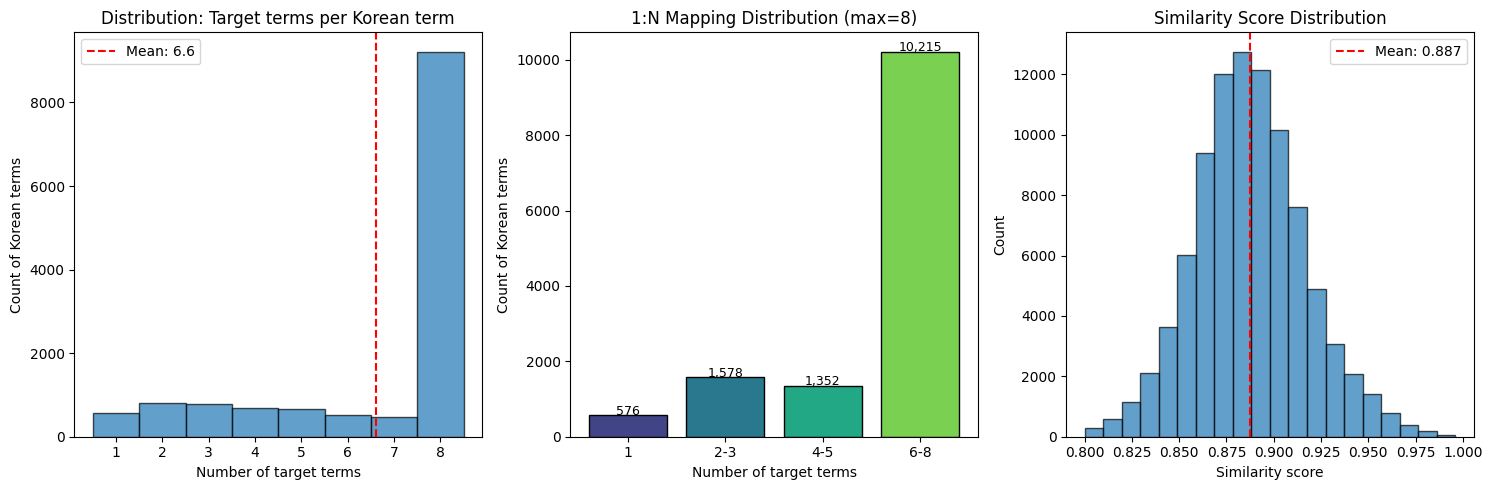

In [23]:
# Visualize distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Histogram of target terms per Korean term
ax1 = axes[0]
ax1.hist(term_counts, bins=range(1, CONFIG['max_targets_per_source'] + 2), 
         edgecolor='black', alpha=0.7, align='left')
ax1.set_xlabel('Number of target terms')
ax1.set_ylabel('Count of Korean terms')
ax1.set_title('Distribution: Target terms per Korean term')
ax1.axvline(np.mean(term_counts), color='red', linestyle='--', label=f'Mean: {np.mean(term_counts):.1f}')
ax1.legend()

# Bar chart for categories
ax2 = axes[1]
categories = ['1', '2-3', '4-5', '6-8']
counts_cat = [
    sum(1 for c in term_counts if c == 1),
    sum(1 for c in term_counts if 2 <= c <= 3),
    sum(1 for c in term_counts if 4 <= c <= 5),
    sum(1 for c in term_counts if 6 <= c <= 8),
]
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(categories)))
bars = ax2.bar(categories, counts_cat, color=colors, edgecolor='black')
ax2.set_xlabel('Number of target terms')
ax2.set_ylabel('Count of Korean terms')
ax2.set_title(f'1:N Mapping Distribution (max={CONFIG["max_targets_per_source"]})')

for bar, count in zip(bars, counts_cat):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
             f'{count:,}', ha='center', fontsize=9)

# Histogram of similarity scores
ax3 = axes[2]
all_sims = [s for v in final_mappings.values() for _, s in v]
ax3.hist(all_sims, bins=20, edgecolor='black', alpha=0.7)
ax3.set_xlabel('Similarity score')
ax3.set_ylabel('Count')
ax3.set_title('Similarity Score Distribution')
ax3.axvline(np.mean(all_sims), color='red', linestyle='--', label=f'Mean: {np.mean(all_sims):.3f}')
ax3.legend()

plt.tight_layout()
plt.show()

In [24]:
# Sample 1:N mappings with mixed Korean/English (with similarity scores)
print("=" * 70)
print("Sample Mappings (Korean -> [Korean + English mixed] with similarity)")
print("=" * 70)

# Show mappings with both Korean and English targets
mixed_mappings = [
    (ko, terms) for ko, terms in final_mappings.items()
    if any(is_korean_token(t) for t, _ in terms) and any(is_english_token(t) for t, _ in terms)
]
print(f"\nMappings with both Korean AND English targets: {len(mixed_mappings):,}")

if mixed_mappings:
    sample_mixed = random.sample(mixed_mappings, min(15, len(mixed_mappings)))
    print("\nSample mixed mappings (with similarity scores):")
    for ko, terms in sorted(sample_mixed, key=lambda x: -len(x[1])):
        terms_str = ", ".join([f"{t}({s:.2f})" for t, s in terms[:6]])
        if len(terms) > 6:
            terms_str += f" ... (+{len(terms)-6})"
        print(f"  {ko} -> [{terms_str}]")

Sample Mappings (Korean -> [Korean + English mixed] with similarity)

Mappings with both Korean AND English targets: 7,909

Sample mixed mappings (with similarity scores):
  터치 -> [터틀(0.92), 터프(0.92), 터치스크린(0.91), 터보(0.91), 터널(0.90), 터커(0.90) ... (+2)]
  니트로 -> [nitro(0.91), 비토(0.90), 알토(0.90), 타이토(0.90), 다이토(0.89), 카토(0.89) ... (+2)]
  최소화 -> [최소화하기(0.97), minimization(0.91), 단순화(0.90), minimise(0.89), minimized(0.88), minimize(0.88) ... (+2)]
  안사르 -> [카이사르(0.91), 마카사르(0.89), ansar(0.89), 디나르(0.87), 발타사르(0.87), 니제르(0.86) ... (+2)]
  어댑터 -> [adapter(0.89), adaptor(0.89), 엑서터(0.88), 랩터(0.88), 벡터(0.88), adapters(0.88) ... (+2)]
  서커스 -> [사이러스(0.90), 스니커즈(0.89), 쿠어스(0.89), 시러큐스(0.88), 융커스(0.88), 파크스(0.87) ... (+2)]
  게이트웨이 -> [스피드웨이(0.91), 갤러웨이(0.90), gateway(0.90), 하이웨이(0.90), 파크웨이(0.89), 리지웨이(0.89) ... (+2)]
  가죽 -> [폭죽(0.93), 반죽(0.91), 반죽이(0.90), 반죽을(0.89), leather(0.87), 반짝(0.87) ... (+1)]
  결합 -> [구성(0.91), 통합(0.90), combine(0.85), combined(0.85), conjoined(0.85), bond(0.83)]
  내셔널 

## 9. Save Dataset

In [25]:
# Create output directory
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Save dataset in 1:N format with similarity scores
# Format: {"ko": "프로그램", "terms": [{"term": "program", "sim": 0.95}, {"term": "소프트웨어", "sim": 0.88}]}
output_path = OUTPUT_DIR / "term_mappings.jsonl"
with open(output_path, "w", encoding="utf-8") as f:
    for ko, terms in final_mappings.items():
        item = {
            "ko": ko,
            "terms": [{"term": t, "sim": round(s, 4)} for t, s in terms]
        }
        f.write(json.dumps(item, ensure_ascii=False) + "\n")

print(f"Dataset saved to: {output_path}")
print(f"Total Korean source terms: {len(final_mappings):,}")
total_terms = sum(len(v) for v in final_mappings.values())
print(f"Total target terms: {total_terms:,}")
print(f"Max targets per source: {CONFIG['max_targets_per_source']}")

file_size = output_path.stat().st_size / 1024
print(f"File size: {file_size:.1f} KB")

# Show sample of saved data
print("\nSample saved data:")
with open(output_path, "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        if i >= 5:
            break
        item = json.loads(line)
        print(f"  {item}")

Dataset saved to: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/dataset/v19_high_quality/term_mappings.jsonl
Total Korean source terms: 13,721
Total target terms: 90,774
Max targets per source: 8
File size: 3693.0 KB

Sample saved data:
  {'ko': '분류', 'terms': [{'term': '분류법', 'sim': 0.9453}, {'term': '분류학', 'sim': 0.9394}, {'term': 'classification', 'sim': 0.8806}, {'term': 'category', 'sim': 0.877}, {'term': 'categories', 'sim': 0.8745}, {'term': 'categorization', 'sim': 0.8538}]}
  {'ko': '토론', 'terms': [{'term': '논의', 'sim': 0.9028}, {'term': '대화', 'sim': 0.8908}, {'term': '협상', 'sim': 0.8878}, {'term': '상담', 'sim': 0.8782}, {'term': '발언', 'sim': 0.8777}, {'term': '회담', 'sim': 0.8773}, {'term': '정상회담', 'sim': 0.8726}, {'term': '포럼', 'sim': 0.8718}]}
  {'ko': '선수', 'terms': [{'term': '기자', 'sim': 0.8916}, {'term': '강사', 'sim': 0.8874}, {'term': '닥터', 'sim': 0.8849}, {'term': '연기자', 'sim': 0.8822}, {'term': '상사', 'sim': 0.8805}, {'term': '스승', 'sim': 0.8803}, {'te

In [26]:
# Save metadata
term_counts = [len(v) for v in final_mappings.values()]
ko_lengths = [len(ko) for ko in final_mappings.keys()]
ko_targets = sum(1 for v in final_mappings.values() for t, _ in v if is_korean_token(t))
en_targets = sum(1 for v in final_mappings.values() for t, _ in v if is_english_token(t))
all_sims = [s for v in final_mappings.values() for _, s in v]

metadata = {
    "version": "v19",
    "format": "1:N mixed with dot product similarity",
    "description": "Korean-English mixed term mappings with dot product similarity scores",
    "embedding_model": CONFIG["embedding_model"],
    "similarity_method": "dot_product (L2-normalized vectors)",
    "n_clusters": CONFIG["n_clusters"],
    "similarity_threshold": CONFIG["similarity_threshold"],
    "max_targets_per_source": CONFIG["max_targets_per_source"],
    "total_korean_source_terms": len(final_mappings),
    "total_target_terms": sum(term_counts),
    "korean_targets": ko_targets,
    "english_targets": en_targets,
    "avg_terms_per_korean": float(np.mean(term_counts)),
    "terms_per_ko_distribution": {
        "min": min(term_counts),
        "max": max(term_counts),
        "mean": float(np.mean(term_counts)),
        "median": float(np.median(term_counts)),
    },
    "similarity_stats": {
        "min": float(min(all_sims)),
        "max": float(max(all_sims)),
        "mean": float(np.mean(all_sims)),
        "median": float(np.median(all_sims)),
    },
    "ko_length_stats": {
        "mean": float(np.mean(ko_lengths)),
        "min": min(ko_lengths),
        "max": max(ko_lengths),
    },
}

metadata_path = OUTPUT_DIR / "metadata.json"
with open(metadata_path, "w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

print(f"Metadata saved to: {metadata_path}")

Metadata saved to: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/dataset/v19_high_quality/metadata.json


## 10. Summary

### Data Format: 1:N Mixed Mapping with Similarity Scores

Each entry maps **one Korean term to multiple Korean AND English terms** with similarity scores:

```json
{"ko": "프로그램", "terms": [{"term": "program", "sim": 0.95}, {"term": "소프트웨어", "sim": 0.88}]}
{"ko": "모델", "terms": [{"term": "model", "sim": 0.92}, {"term": "모델링", "sim": 0.85}]}
```

### Key Configuration

| Parameter | Value | Description |
|-----------|-------|-------------|
| `similarity_threshold` | 0.85 | Minimum cosine similarity for inclusion (increased for quality) |
| `max_targets_per_source` | 8 | Maximum target terms per Korean source |

### Data Collection Approach

1. **Extract tokens** from Wikipedia (Korean & English)
2. **Vectorize** using multilingual embedding model (e5-large-multilingual)
3. **K-means clustering** to group semantically similar terms
4. **Extract 1:N mixed mappings** - for each Korean term, find top 8 most similar terms (both Korean and English) above 0.85 similarity

### Benefits

- **Mixed Korean/English**: Enables both cross-lingual AND monolingual expansion
- **Limited targets**: Max 8 targets focuses learning on high-quality pairs
- **Similarity weights**: Allows weighted loss during training
- **High threshold**: 0.85 similarity ensures quality over quantity

### Next Steps

1. **Run training** using `02_training.ipynb` (updated for similarity-weighted loss)
2. **Test the model** using `03_inference_test.ipynb`